# Env setup

In [34]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = [12, 10]

# Template setup
Define a burst with an expotantial rise plus a power-law decay, with timescales $t_{pre}$ , $t_{post}$, power-law index $\alpha$ and an $\rm offset$ from 0s.

In [35]:
def burst(t, t_pre=0.2, t_post=1, alpha=-3, offset=0):
    pre = np.exp(-(t[t <= offset+4*t_pre]-(offset+4*t_pre))**2/(2*t_pre**2))
    post = ((t[t > offset+4*t_pre]+t_post-offset-4*t_pre)/1)**alpha
    return np.append(pre, post)

# Signal Synthesis

## Burst
Assuming a $1024\rm Hz$ sample. We bury a burst signal by setting $t_{pre} = 0.2\rm s$ , $t_{post} = 1\rm s$ , $\alpha = -3$ and $\rm offset = 3s$.

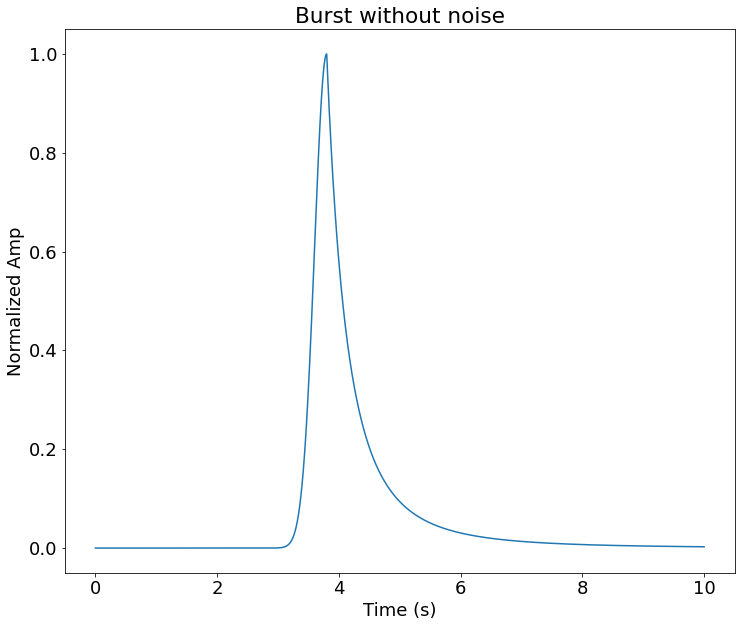

In [36]:
# Init
sample = 1024  # Sample frequency
time = np.arange(0, 10, 1/sample)

# Template setup (partially selected)
template = burst(time)[:time.size//2]

# Signal setup
sig = burst(time, offset=3)
plt.title('Burst without noise')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Amp')
plt.plot(time, sig)

## Noise
Adding normal-distributed noise with amplitude twice than the signal

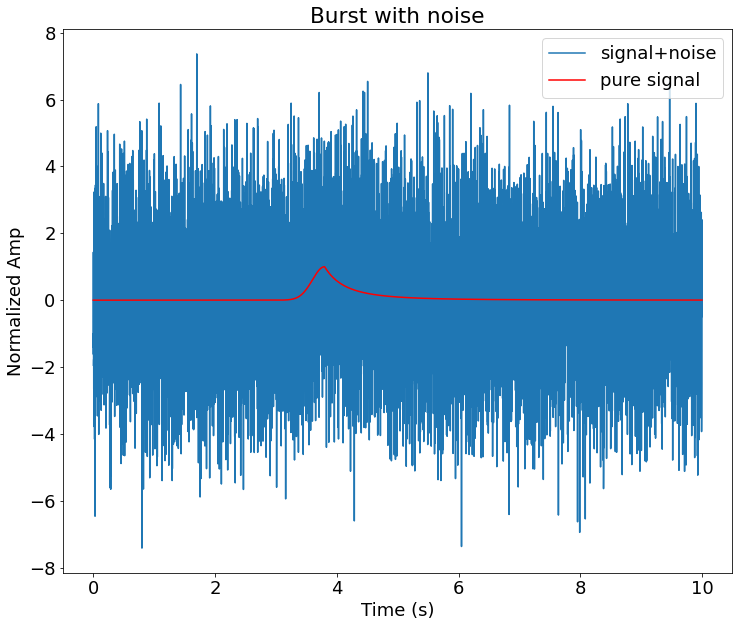

In [37]:
signal = sig + np.random.normal(loc=0, scale=2, size=time.size)
plt.title('Burst with noise')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Amp')
plt.plot(time, signal, label='signal+noise')
plt.plot(time, sig, 'r', label='pure signal')
plt.legend()

# Matched filter

## Calculate the ASD of signal and template

In [38]:
signal_psd, signal_freq = plt.psd(signal[6*sample:], Fs=sample, NFFT=sample, visible=False)
temp_psd, temp_freq = plt.psd(template, Fs=sample, NFFT=sample, visible=False)
plt.close()

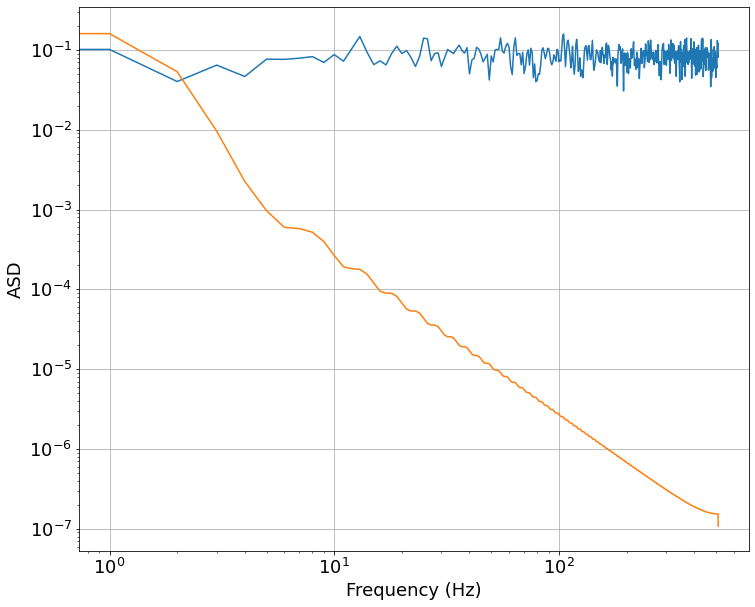

In [39]:
plt.loglog(signal_freq, np.sqrt(signal_psd))
plt.loglog(temp_freq, np.sqrt(temp_psd))
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD')
plt.grid('on')

## Optimal matched filter

In [40]:
signal_fft = np.fft.fft(signal)
zero_pad = np.zeros(signal.size - template.size)
template_padded = np.append(template, zero_pad)
template_fft = np.fft.fft(template_padded)
signalfreq = np.fft.fftfreq(signal.size)*sample
power_vec = np.interp(signalfreq, signal_freq, signal_psd)
optimal = signal_fft * template_fft.conjugate() / power_vec

## Normalization \& visulization

Text(0, 0.5, 'SNR')

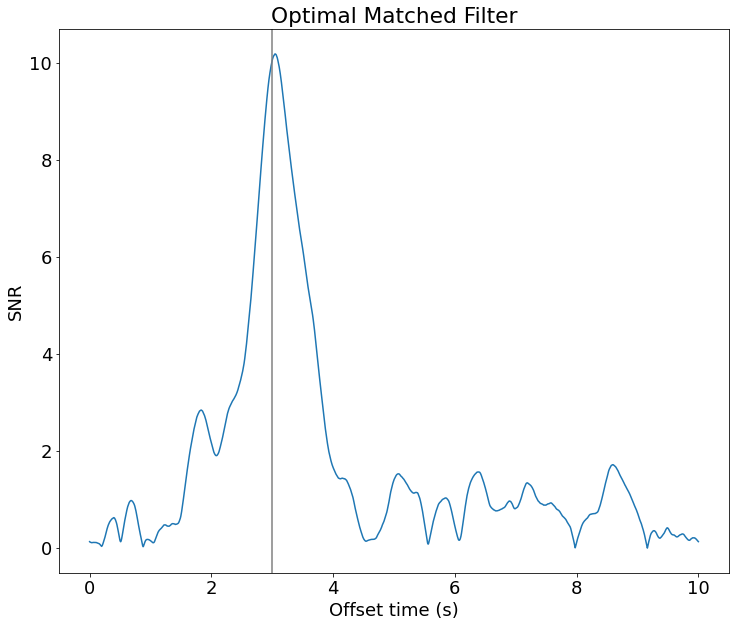

In [41]:
optimal_time = 2*np.fft.ifft(optimal)
df = np.abs(signalfreq[1] - signalfreq[0])
sigmasq = 2*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR = abs(optimal_time) / (sigma)
plt.figure()
plt.plot(time, SNR)
plt.axvline(3, color='grey')
plt.title(r'Optimal Matched Filter')
plt.xlabel('Offset time (s)')
plt.ylabel('SNR')